In [1]:
import random
import numpy as np

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
class Bettor():
    
    def __init__(self,
                 nav=1_000,
                 win_probability=0.5,
                 commission=0.00,
                 minimum_bet_amount=1,
                 maximum_bet_amount=5_000,
                 return_rate=2,
                 fixed_amount=1,
                 proportion=0.01,
                 martingale_multiplier=2,
                 reversed_martingale_multiplier=2,
                 strategy='proportion'
        ):
        self.initial_nav = nav
        self.nav = self.initial_nav
        self.win_probability = win_probability
        self.commission = commission
        self.minimum_bet_amount = minimum_bet_amount
        self.maximum_bet_amount = maximum_bet_amount
        self.return_rate = return_rate
        
        self.total_bet_placed = 0
        self.total_bet_won = 0
        self.total_bet_lost = 0
        self.first_bet = True
        self.last_bet_amount = 0
          
        self.fixed_amount = fixed_amount
        self.proportion = proportion
        self.martingale_base_amount = self.minimum_bet_amount
        self.martingale_multiplier = martingale_multiplier
        self.reversed_martingale_base_amount = self.minimum_bet_amount
        self.reversed_martingale_multiplier = reversed_martingale_multiplier
        
        self.strategy = strategy
        
        self.records = [{'no': 0, 'nav': self.initial_nav, 'bet_amount': 0, 'status': None}]
        
    # Setting up a bet
    def check_enough_nav(self):
        '''To check if nav is enough to make a bet.'''
        if self.nav < self.minimum_bet_amount:
            return False
        return True
    
    def final_bet_amount(self, bet_amount):
        '''The bet amount cannot be larger than the maximum amount allowed.'''
        return min(bet_amount, self.maximum_bet_amount, self.nav)
    
    def bet(self, bet_amount):
        '''To create a bet.'''
        self.nav -= bet_amount
        self.total_bet_placed += 1
        self.last_bet_amount = bet_amount
        self.first_bet = False
            
        # Add to records
        self.records.append({'no': self.total_bet_placed, 'nav': self.nav, 'bet_amount': bet_amount})
        
    def return_amount(self, bet_amount):
        return self.return_rate * bet_amount * (1 - self.commission)
    
    def win(self, return_amount):
        self.nav += return_amount
        self.total_bet_won += 1
        self.last_bet = 'win'
        
        # Add to records
        self.records[-1]['nav'] += return_amount
        self.records[-1]['status'] = 'win'
    
    def lose(self):
        self.total_bet_lost += 1
        self.last_bet = 'lost'
        
        # Add to records
        self.records[-1]['status'] = 'lost'
    
    def result(self):
        if random.random() < self.win_probability:
            return 'win'
        else:
            return 'lost'
    
    # A full bet
    def full_bet(self, bet_amount):
        if self.check_enough_nav():
            final_bet_amount = self.final_bet_amount(bet_amount)
            self.bet(final_bet_amount)
            return_amount = self.return_amount(final_bet_amount)
            
            if self.result() == 'win':
                self.win(return_amount)
            else:
                self.lose()  
        else:
            pass
        
    
    # Betting strategy
    def all_in_bet(self):
        def bet_amount():
            return self.nav
        
        self.full_bet(bet_amount())

    def fixed_amount_bet(self):
        def bet_amount():
            return self.minimum_bet_amount
        
        self.full_bet(bet_amount())        

    def proportion_bet(self):
        def bet_amount():
            return self.proportion * self.nav
        
        self.full_bet(bet_amount())        
        
    def martingale_bet(self):
        def bet_amount():
            if self.first_bet or self.last_bet == 'win':
                return self.martingale_base_amount
            else:
                return self.martingale_multiplier * self.last_bet_amount
            
        self.full_bet(bet_amount())
            
    def reversed_martingale_bet(self):
        def bet_amount():
            def feeling_lucky():
                '''The bettor has 50% chance to multiply bet amount after a win to make the streak longer.'''
                if random.random() < 0.5:
                    return True
                else:
                    return False
            
            if self.first_bet or self.last_bet == 'lost':
                return self.reversed_martingale_base_amount
            else:
                if feeling_lucky():
                    return self.reversed_martingale_multiplier * self.last_bet_amount
                return self.reversed_martingale_base_amount
            
        self.full_bet(bet_amount())
        
    def fibonacci_bet(self):
        def bet_amount():
            if self.total_bet_placed < 2 or self.records[-1]['status'] == 'win' or self.records[-2]['status'] == 'win':
                return self.minimum_bet_amount
            else:
                return self.records[-1]['bet_amount'] + self.records[-2]['bet_amount']
        
        self.full_bet(bet_amount())
    
    def sequence_1326_bet(self):
        def bet_amount():
            bet_sequence = [1, 3, 2, 6]
            if self.first_bet == True or self.last_bet == 'lost':
                return self.minimum_bet_amount
            else:
                multiplier = int(self.records[-1]['bet_amount'] / self.minimum_bet_amount)
                index = bet_sequence.index(multiplier)
                next_multiplier = bet_sequence[(index+1) % len(bet_sequence)]
                return next_multiplier * self.minimum_bet_amount
        
        self.full_bet(bet_amount())
    
    # Making bets
    def bet_loop(self, r=10_000):
        for i in range(r):
            if self.strategy == 'all_in':
                self.all_in_bet()
            elif self.strategy == 'fixed_amount':
                self.fixed_amount_bet()
            elif self.strategy == 'proportion':
                self.proportion_bet()
            elif self.strategy == 'martingale':
                self.martingale_bet()
            elif self.strategy == 'reversed_martingale':
                self.reversed_martingale_bet()
            elif self.strategy == 'fibonacci':
                self.fibonacci_bet()
            elif self.strategy == 'sequence_1326':
                self.sequence_1326_bet()
    
    # Checking stats
    def report(self, write=True):
        # Total rounds
        if write == True:
            print('This bettor has placed {} bet(s), including {} win(s) and {} loss(es).'.format(self.total_bet_placed,
                                                                                                  self.total_bet_won,
                                                                                                  self.total_bet_lost
                                                                                                 ))
        
        # Profit
        profit = self.nav - self.initial_nav
        if write == True:
            print("This bettor has profit: {:.02f}, which is equivalent to {:.02f}%.".format(profit, profit / self.initial_nav * 100))
        
        # Win rate
        if self.total_bet_placed == 0:
            win_rate = 0
            if write == True:
                print('This bettor has not placed any bet.')
        else:
            win_rate = self.total_bet_won / self.total_bet_placed
            if write == True:
                print('Win rate: {:.2f}%'.format(win_rate * 100))
        
        return self.total_bet_placed, \
            self.total_bet_won, \
            self.total_bet_lost, \
            profit, \
            win_rate

This bettor has placed 15 bet(s), including 8 win(s) and 7 loss(es).
This bettor has profit: -1000.00, which is equivalent to -100.00%.
Win rate: 53.33%


<AxesSubplot:>

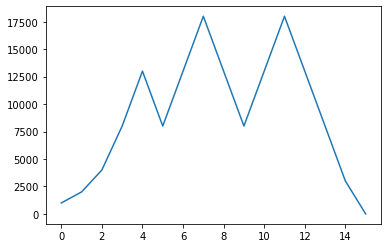

In [4]:
a = Bettor(strategy='all_in')
a.bet_loop()
a.report()
df = pd.DataFrame(a.records)
df.nav.plot()

This bettor has placed 10000 bet(s), including 4914 win(s) and 5086 loss(es).
This bettor has profit: -172.00, which is equivalent to -17.20%.
Win rate: 49.14%


<AxesSubplot:>

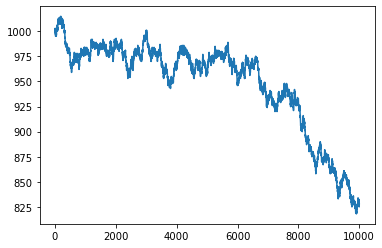

In [5]:
b = Bettor(strategy='fixed_amount')
b.bet_loop()
b.report()
df = pd.DataFrame(b.records)
df.nav.plot()

This bettor has placed 10000 bet(s), including 4996 win(s) and 5004 loss(es).
This bettor has profit: -440.12, which is equivalent to -44.01%.
Win rate: 49.96%


<AxesSubplot:>

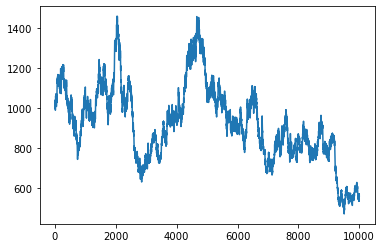

In [6]:
c = Bettor(strategy='proportion')
c.bet_loop()
c.report()
df = pd.DataFrame(c.records)
df.nav.plot()

This bettor has placed 1476 bet(s), including 708 win(s) and 768 loss(es).
This bettor has profit: -1000.00, which is equivalent to -100.00%.
Win rate: 47.97%


<AxesSubplot:>

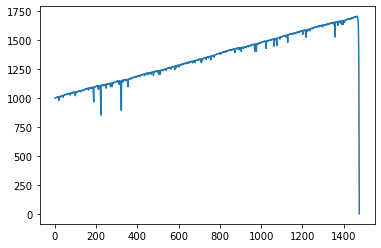

In [7]:
d = Bettor(strategy='martingale')
d.bet_loop()
d.report()
df = pd.DataFrame(d.records)
df.nav.plot()

This bettor has placed 10000 bet(s), including 5003 win(s) and 4997 loss(es).
This bettor has profit: 471.00, which is equivalent to 47.10%.
Win rate: 50.03%


<AxesSubplot:>

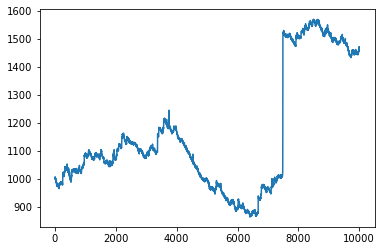

In [8]:
e = Bettor(strategy='reversed_martingale')
e.bet_loop()
e.report()
df = pd.DataFrame(e.records)
df.nav.plot()

This bettor has placed 10000 bet(s), including 5036 win(s) and 4964 loss(es).
This bettor has profit: 344.00, which is equivalent to 34.40%.
Win rate: 50.36%


<AxesSubplot:>

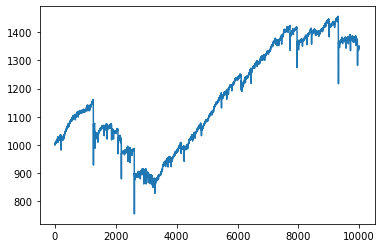

In [9]:
f = Bettor(strategy='fibonacci')
f.bet_loop()
f.report()
df = pd.DataFrame(f.records)
df.nav.plot()

This bettor has placed 10000 bet(s), including 4988 win(s) and 5012 loss(es).
This bettor has profit: -242.00, which is equivalent to -24.20%.
Win rate: 49.88%


<AxesSubplot:>

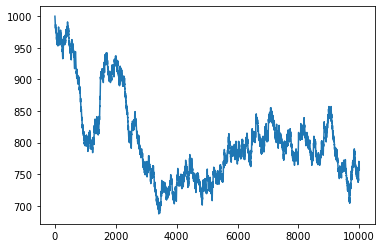

In [10]:
g = Bettor(strategy='sequence_1326')
g.bet_loop()
g.report()
df = pd.DataFrame(g.records)
df.nav.plot()

In [11]:
def get_bet_result(strategy='proportion', n=10_000, commission=0.00):
    from tqdm import tqdm
    from matplotlib import pyplot as plt
    import statistics as st
    
    sum_total_bet_placed = 0
    sum_total_bet_won = 0
    sum_total_bet_lost = 0
    sum_profit = 0
    sum_win_rate = 0
    profit_list = []
    
    for i in tqdm(range(n)):
        bettor = Bettor(strategy=strategy, commission=commission)
        bettor.bet_loop()
        total_bet_placed, \
        total_bet_won, \
        total_bet_lost, \
        profit, \
        win_rate = bettor.report(write=False)
        
        sum_total_bet_placed += total_bet_placed
        sum_total_bet_won += total_bet_won
        sum_total_bet_lost += total_bet_lost
        sum_profit += profit
        profit_list.append(profit)
    
    # Final result
    avg_total_bet_placed = sum_total_bet_placed / n
    avg_total_bet_won = sum_total_bet_won / n
    avg_total_bet_lost = sum_total_bet_lost / n
    avg_profit = sum_profit / n
    avg_win_rate = sum_total_bet_won / sum_total_bet_placed
    med_profit = st.median(profit_list)
    num_has_profit = len([x for x in profit_list if x > 0])
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    axes = ax.ravel()
    axes[0].plot(profit_list)
    axes[1].hist(profit_list, bins=50)
    
    print('Simulation for {} bettors with strategy {}...'.format(n, strategy))
    print('Average bet placed: {:.2f}.'.format(avg_total_bet_placed))
    print('Average bet won: {:.2f}.'.format(avg_total_bet_won))
    print('Average bet lost: {:.2f}.'.format(avg_total_bet_lost))
    print('Average profit: {:.2f}.'.format(avg_profit))
    print('Median profit: {:.2f}.'.format(med_profit))
    print('Chance to have profit: {:.4f}%'.format(num_has_profit/n*100))
    print('Average win rate: {:.2f}%.'.format(avg_win_rate * 100))

100%|██████████| 10000/10000 [00:42<00:00, 234.14it/s]


Simulation for 10000 bettors with strategy all_in...
Average bet placed: 33.83.
Average bet won: 16.90.
Average bet lost: 16.94.
Average profit: -229.40.
Median profit: -1000.00.
Chance to have profit: 0.1400%
Average win rate: 49.94%.


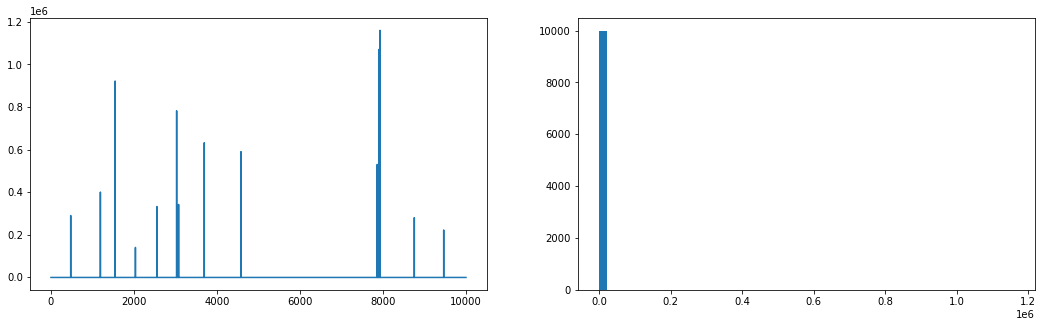

In [12]:
get_bet_result('all_in')

100%|██████████| 10000/10000 [03:08<00:00, 53.16it/s]


Simulation for 10000 bettors with strategy fixed_amount...
Average bet placed: 10000.00.
Average bet won: 4999.55.
Average bet lost: 5000.45.
Average profit: -0.90.
Median profit: 0.00.
Chance to have profit: 49.6000%
Average win rate: 50.00%.


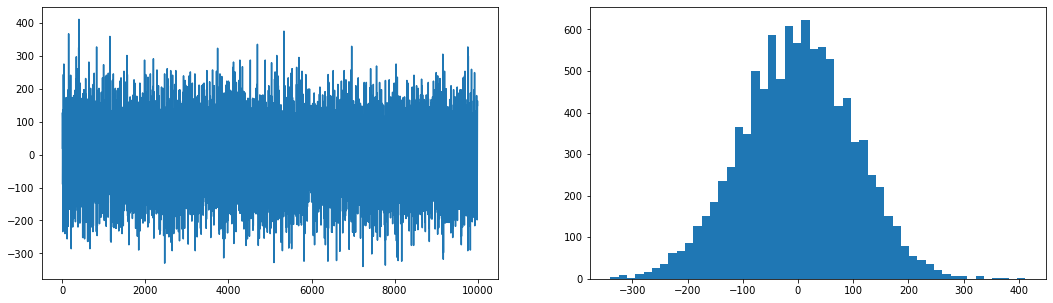

In [13]:
get_bet_result('fixed_amount')

100%|██████████| 10000/10000 [03:18<00:00, 50.44it/s]


Simulation for 10000 bettors with strategy proportion...
Average bet placed: 10000.00.
Average bet won: 4999.46.
Average bet lost: 5000.54.
Average profit: -7.19.
Median profit: -393.48.
Chance to have profit: 29.9700%
Average win rate: 49.99%.


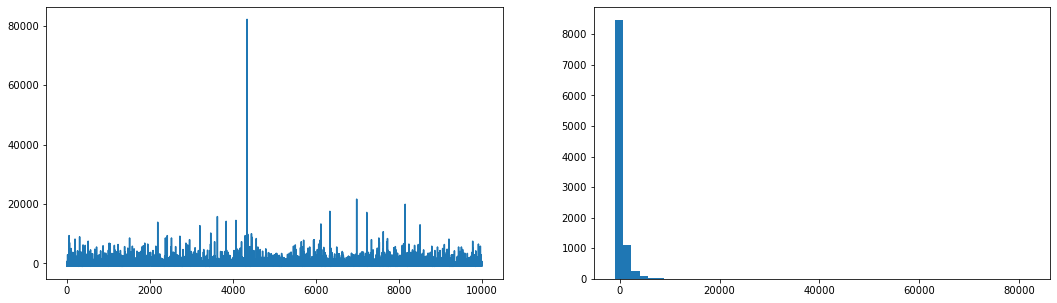

In [14]:
get_bet_result('proportion')

100%|██████████| 10000/10000 [02:06<00:00, 79.32it/s]


Simulation for 10000 bettors with strategy martingale...
Average bet placed: 3980.61.
Average bet won: 1990.02.
Average bet lost: 1990.59.
Average profit: -4.22.
Median profit: -1000.00.
Chance to have profit: 19.1900%
Average win rate: 49.99%.


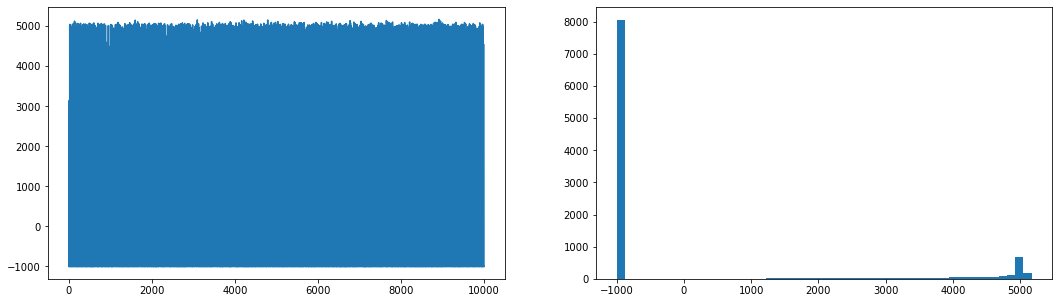

In [15]:
get_bet_result('martingale')

100%|██████████| 10000/10000 [03:39<00:00, 45.46it/s]


Simulation for 10000 bettors with strategy reversed_martingale...
Average bet placed: 10000.00.
Average bet won: 5000.49.
Average bet lost: 4999.51.
Average profit: -0.18.
Median profit: -30.00.
Chance to have profit: 44.3700%
Average win rate: 50.00%.


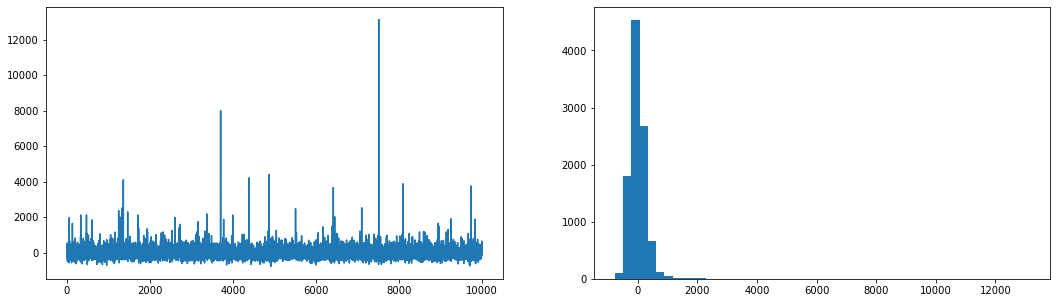

In [16]:
get_bet_result('reversed_martingale')

100%|██████████| 10000/10000 [03:27<00:00, 48.10it/s]


Simulation for 10000 bettors with strategy fibonacci...
Average bet placed: 8928.25.
Average bet won: 4464.10.
Average bet lost: 4464.15.
Average profit: -7.53.
Median profit: 198.00.
Chance to have profit: 65.2300%
Average win rate: 50.00%.


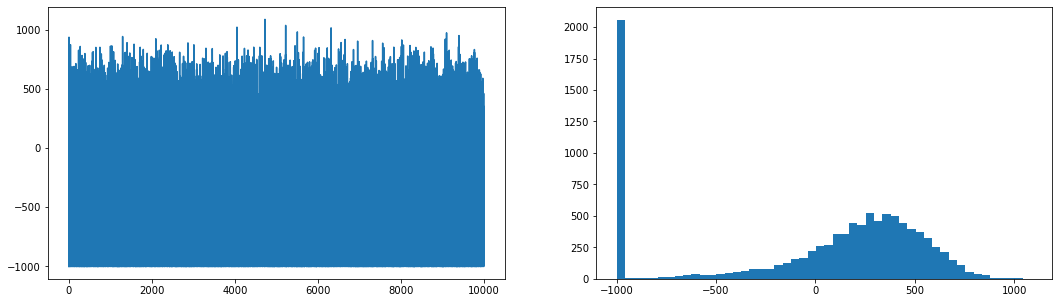

In [17]:
get_bet_result('fibonacci')

100%|██████████| 10000/10000 [19:29<00:00,  8.55it/s]  


Simulation for 10000 bettors with strategy sequence_1326...
Average bet placed: 10000.00.
Average bet won: 5000.40.
Average bet lost: 4999.60.
Average profit: 2.20.
Median profit: 1.00.
Chance to have profit: 50.1700%
Average win rate: 50.00%.


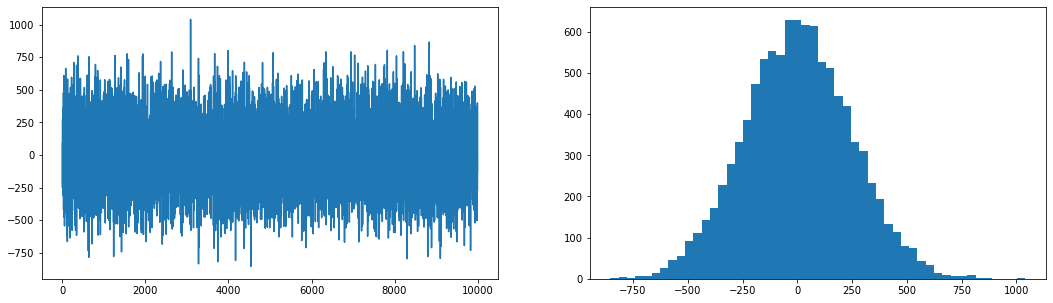

In [18]:
get_bet_result('sequence_1326')

100%|██████████| 10000/10000 [03:24<00:00, 48.81it/s]


Simulation for 10000 bettors with strategy fibonacci...
Average bet placed: 8507.29.
Average bet won: 4253.73.
Average bet lost: 4253.56.
Average profit: -485.39.
Median profit: -398.83.
Chance to have profit: 11.6800%
Average win rate: 50.00%.


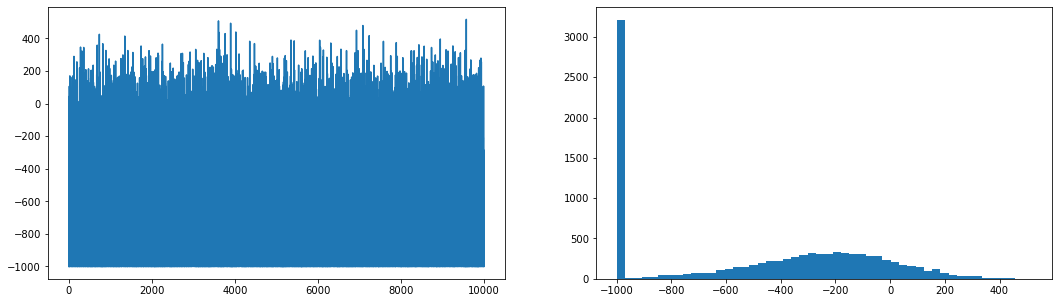

In [19]:
get_bet_result('fibonacci', commission=0.03)

100%|██████████| 10000/10000 [03:27<00:00, 48.19it/s]


Simulation for 10000 bettors with strategy fibonacci...
Average bet placed: 8918.28.
Average bet won: 4459.31.
Average bet lost: 4458.97.
Average profit: -52.10.
Median profit: 136.30.
Chance to have profit: 61.2200%
Average win rate: 50.00%.


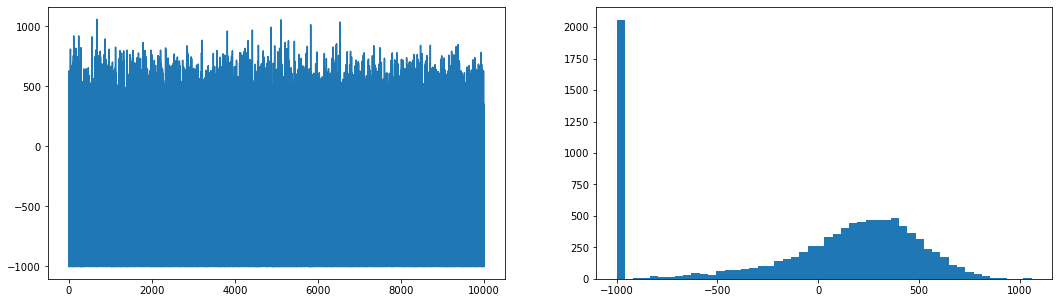

In [ ]:
get_bet_result('fibonacci', commission=0.003)

100%|██████████| 10000/10000 [00:42<00:00, 235.13it/s]


Simulation for 10000 bettors with strategy all_in...
Average bet placed: 7.63.
Average bet won: 3.81.
Average bet lost: 3.82.
Average profit: -1000.00.
Median profit: -1000.00.
Chance to have profit: 0.0000%
Average win rate: 49.94%.


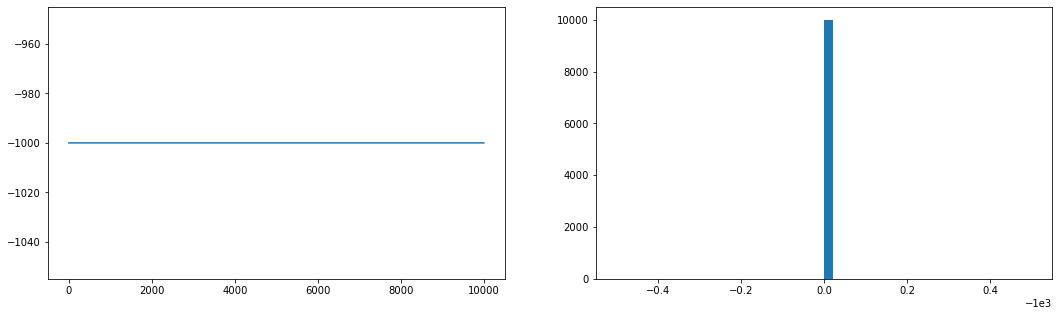

In [ ]:
get_bet_result('all_in', commission=0.03)

100%|██████████| 10000/10000 [00:42<00:00, 233.38it/s]


Simulation for 10000 bettors with strategy all_in...
Average bet placed: 25.30.
Average bet won: 12.64.
Average bet lost: 12.66.
Average profit: -401.00.
Median profit: -1000.00.
Chance to have profit: 0.1100%
Average win rate: 49.96%.


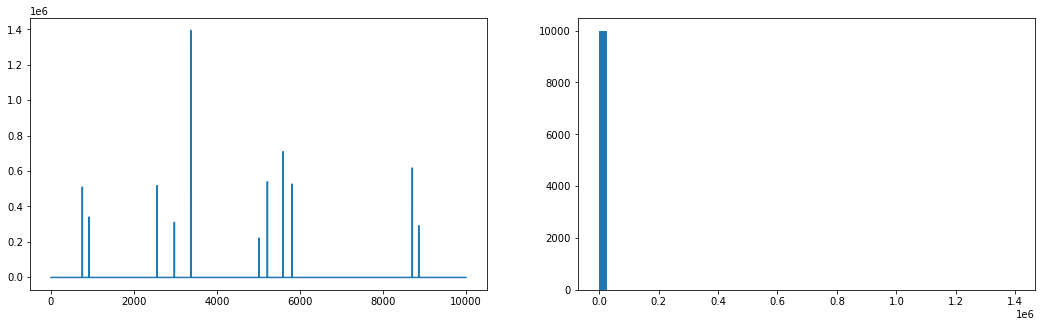

In [ ]:
get_bet_result('all_in', commission=0.003)